In [1]:
"""
    Asset Allocation Model
    Two Leveraged ETFs with target weight
    Leverage ETFs: TQQQ, TMF
    Rebalancing: No
"""
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, get_datetime, set_benchmark
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [2]:
def initialize(context):
    # ETFs and target weight
    context.securities = {
        'TQQQ': 0.60,
        'TMF': 0.40
    }
    
    set_benchmark(symbol('SPY'))

    context.has_ordered = False
    

In [3]:
def handle_data(context, data):
    # trading logic
    if not context.has_ordered:
        for sec, weight in context.securities.items():
            sym = symbol(sec)
            order_target_percent(sym, weight)
        # setting up a flag for holding a position
        context.has_ordered = True

In [4]:
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf

In [5]:
def analyze(context, perf):
    # Extract algo returns and benchmark returns
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    benchmark_period_return = perf['benchmark_period_return']
    
    # Convert benchmark returns to daily returns
    #daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
    daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
    
    # Create tear sheet
    # Live start date is Bogleheads forum HEDGEFUNDIE's post start date https://www.bogleheads.org/forum/viewtopic.php?f=10&t=272007
    pf.create_full_tear_sheet(live_start_date='2019-02-05', returns = returns, positions = positions, transactions = transactions, round_trips = True, benchmark_rets=daily_benchmark_returns) 

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,66.13,2020-02-19,2020-03-20,2020-07-10,103
1,55.66,2018-08-29,2018-12-24,2019-11-01,308
2,34.93,2015-07-20,2016-02-09,2016-07-27,268
3,34.13,2020-09-02,2020-09-23,2020-12-17,77
4,30.17,2021-02-12,2021-03-08,2021-04-15,45


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.14%,-7.20%,7.86%
Fukushima,0.19%,-4.30%,3.35%
EZB IR Event,-0.33%,-3.50%,2.10%
Flash Crash,-0.81%,-6.27%,5.84%
Apr14,0.07%,-7.18%,4.02%
Oct14,0.33%,-5.69%,5.85%
Fall2015,-0.64%,-10.30%,10.47%
Recovery,0.14%,-7.20%,7.86%
New Normal,0.21%,-29.56%,22.86%


Top 10 long positions of all time,max
sid,
TQQQ,98.23%
TMF,57.52%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
TQQQ,98.23%
TMF,57.52%


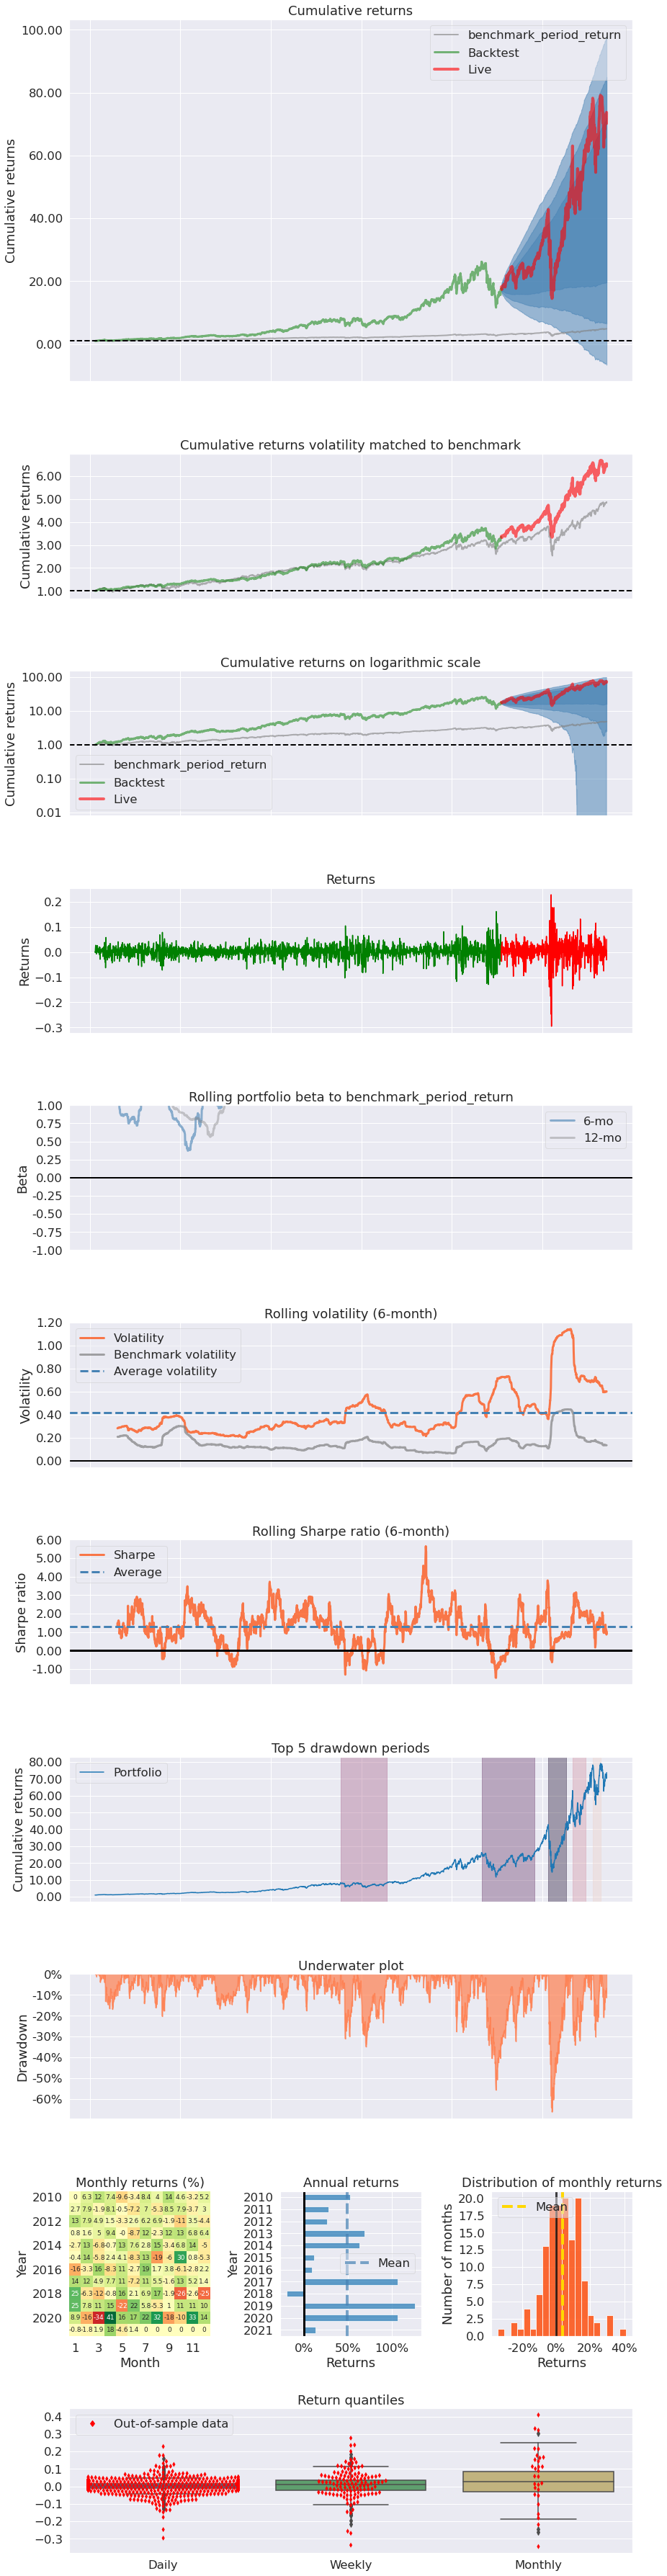

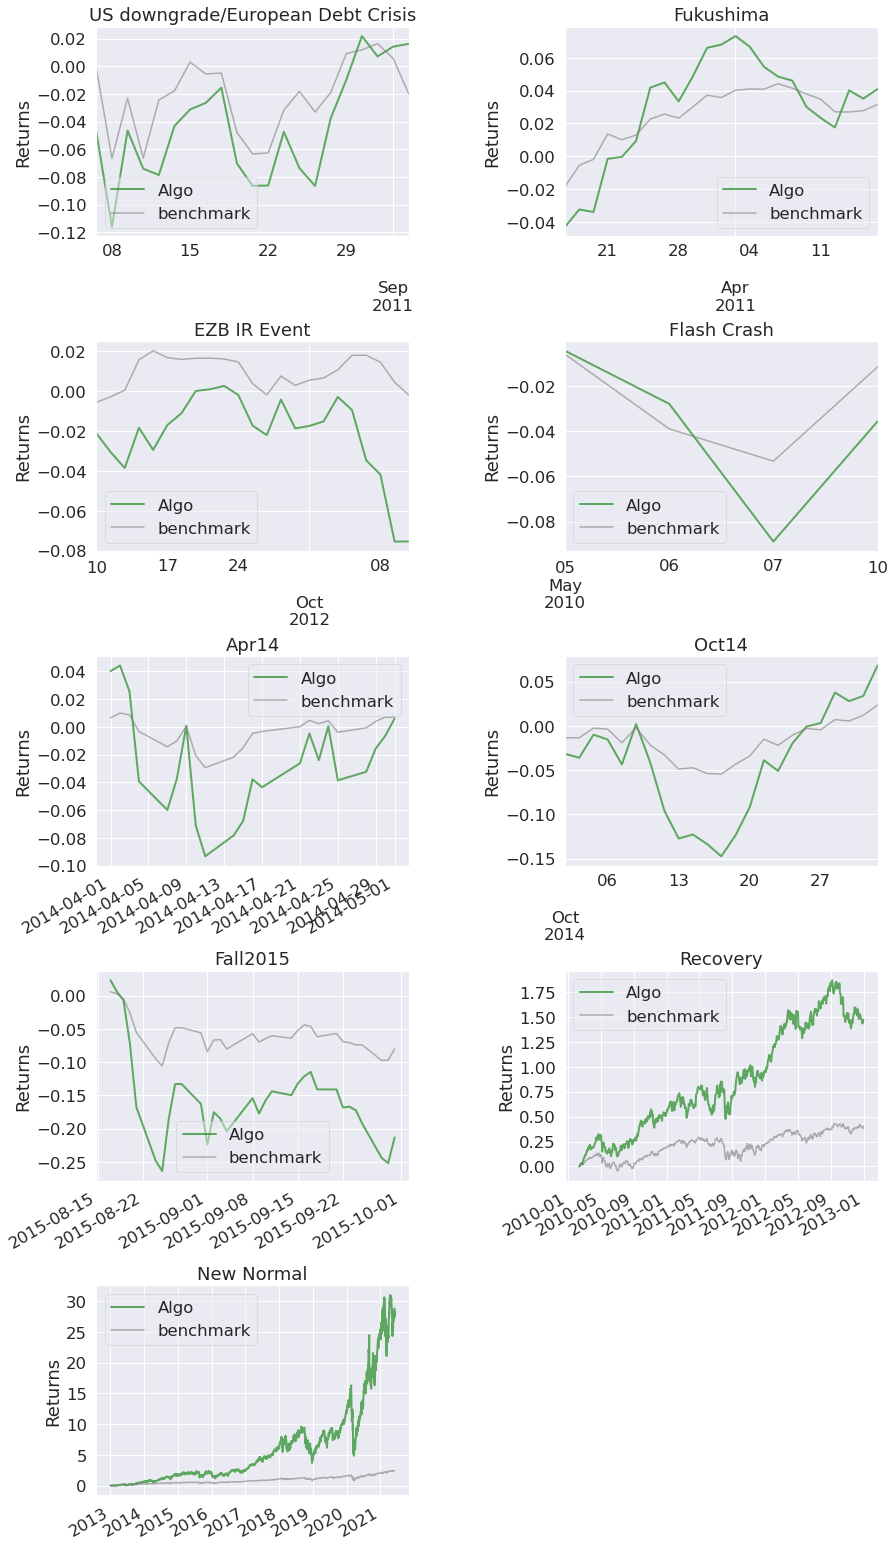

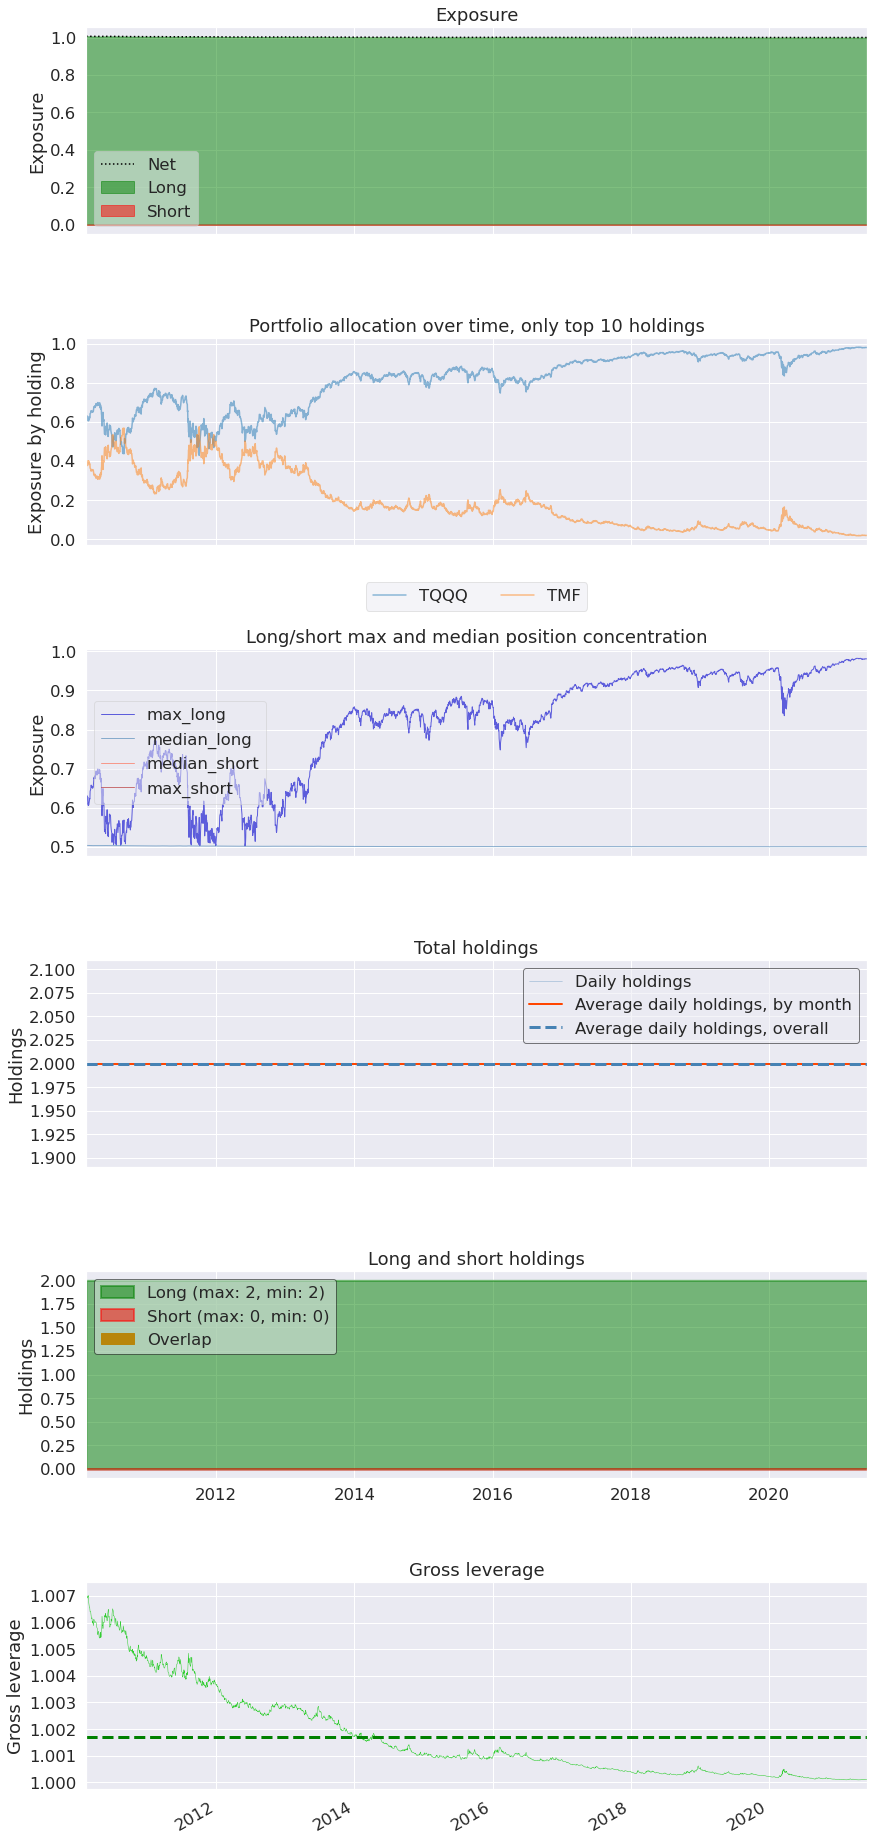

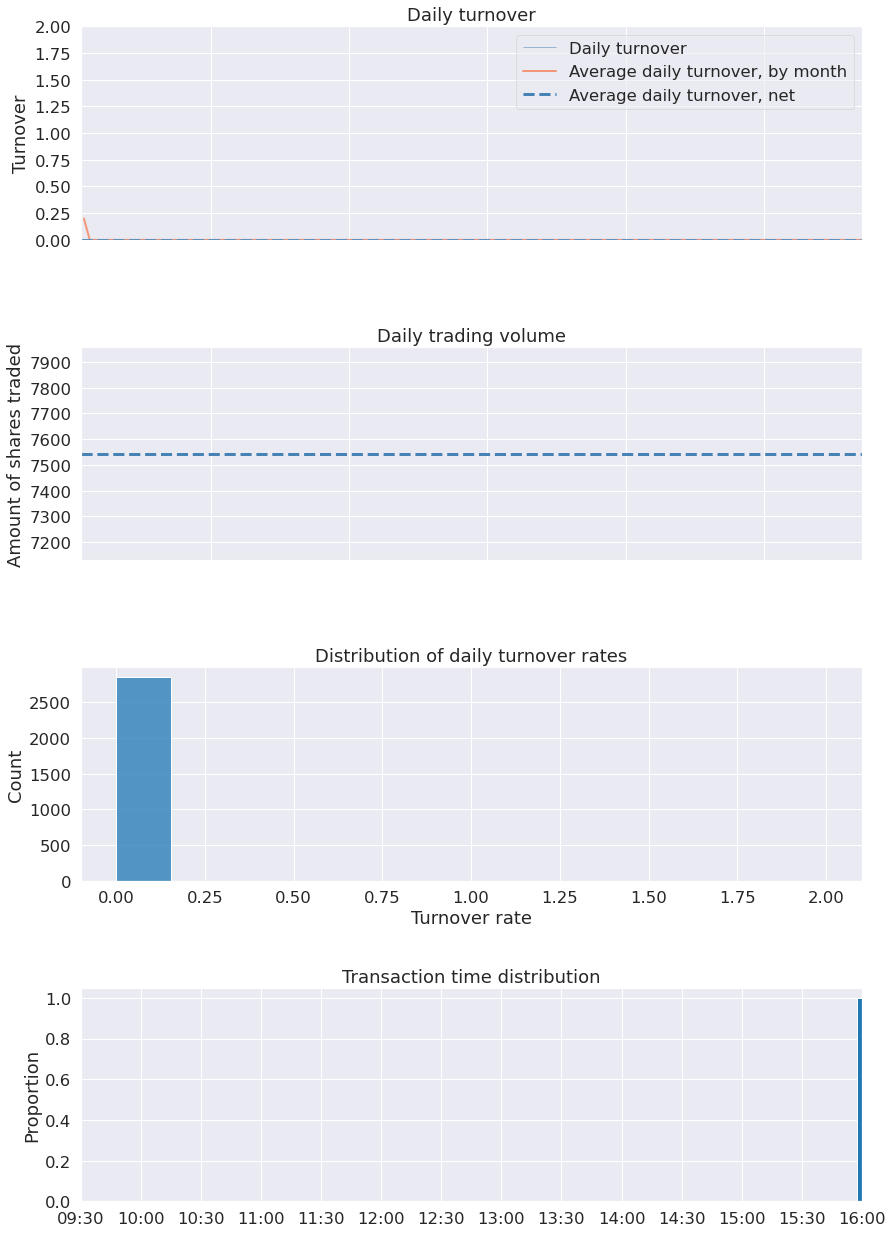

In [6]:
# Set start and end
start = pd.to_datetime('2010-02-11', utc=True)
end = pd.to_datetime('2021-06-04', utc=True)

# Fire off backtest
result = zipline.run_algorithm(
    start = start, 
    end = end, 
    initialize = initialize,
    handle_data = handle_data,
    analyze = analyze,
    capital_base = 10000, 
    data_frequency = 'daily', 
    bundle = 'etf_db_data'
)

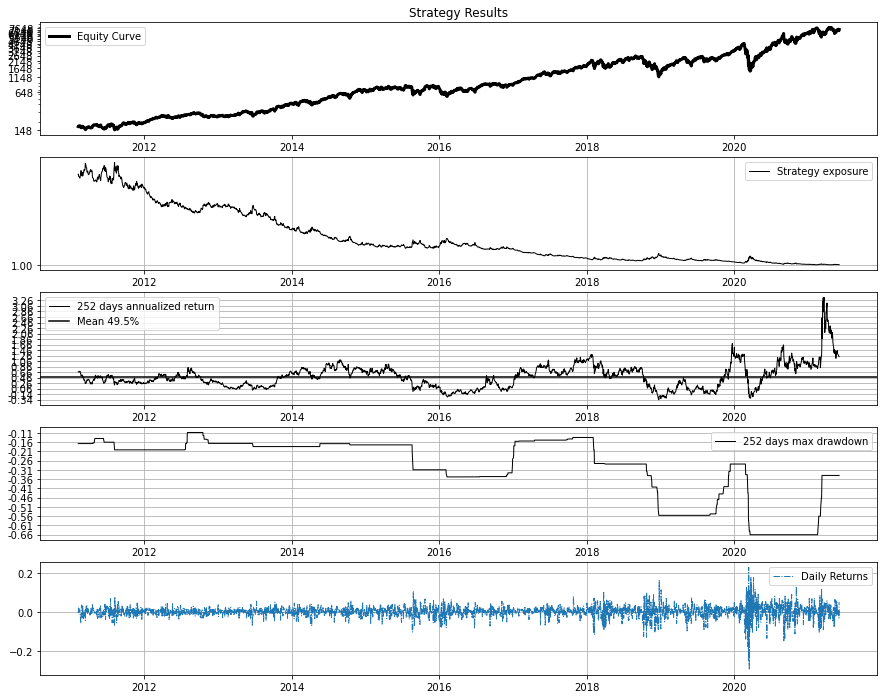

In [7]:
# Settings
window = 252
year_length = 252

# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage', 'returns'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(15, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(511)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(512)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.01 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(513)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)
ax.axhline(df['annualized'].mean(), color='black', linewidth=1.5, 
           label='Mean {:0.1f}%'.format(df['annualized'].mean() * 100))

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.2 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(514)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.05 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fifth chart
ax = fig.add_subplot(515)
ax.plot(df['returns'], label = 'Daily Returns', linestyle='-.', linewidth = 1.0)
ax.legend()
ax.grid(True)

In [8]:
"""
    Monthly Time Return Table
"""


# Used for performance calculations
import empyrical as em

# Used for displaying HTML formatted content in notebook
from IPython.core.display import display, HTML

# Use Empyrical to aggregate on monthly and yearly periods
monthly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'monthly')
yearly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')

# Start off an HTML table for display
# HTML Table for display
table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>"""

# initialize
first_year = True
first_month = True
yr = 0
mnth = 0

# iterate over pandas series
for m, val in monthly_data.iteritems():
    yr = m[0]
    mnth = m[1]
    
    # first month of year, add year label to table
    if (first_month):
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False
    
    # pad empty months for first year if simulation starts later in year
    if (first_year):
        first_year = False
        if (mnth > 1):
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"
                
    # add monthly performance
    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)
    
    # check for 12th month, add annual return number
    if (mnth == 12):
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += '</tr>\n<tr>\n'
        first_month = True
        
# pad empty months for last year
if (mnth != 12):
    for i in range(mnth + 1, 13):
        table +="<td align='right'><b>\n"
        if (i == 12):
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
            table += '</tr>\n<tr>\n'

# finalize table
table += '</tr>\n</tbody>\n</table>'

display(HTML(table))

Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2010,-,+6.3,+12.2,+7.4,-9.6,-3.4,+8.4,+4.0,+13.8,+4.6,-3.2,+5.2,+52.9
2011,+2.7,+7.9,-1.9,+8.1,-0.5,-7.2,+7.0,-5.3,+8.5,+7.9,-3.7,+3.0,+27.7
2012,+12.7,+7.9,+4.9,+1.5,-3.3,+2.6,+6.2,+6.9,-1.9,-10.6,+3.5,-4.4,+26.6
2013,+0.8,+1.6,+5.0,+9.4,-0.0,-8.7,+12.5,-2.3,+11.9,+12.6,+6.8,+6.4,+69.0
2014,-2.7,+13.0,-6.8,-0.7,+12.7,+7.6,+2.8,+15.3,-3.4,+6.8,+13.5,-5.0,+63.0
2015,-0.4,+13.5,-5.8,+2.4,+4.1,-8.3,+13.4,-18.8,-6.0,+30.3,+0.8,-5.3,+11.9
2016,-15.9,-3.3,+16.4,-8.3,+10.7,-2.7,+18.9,+1.7,+3.8,-6.1,-2.8,+2.2,+9.5
2017,+14.1,+12.4,+4.9,+7.7,+10.9,-7.2,+11.2,+5.5,-1.6,+12.6,+5.2,+1.4,+106.8
2018,+25.1,-6.3,-12.3,-0.8,+16.3,+2.1,+6.9,+17.0,-1.9,-26.0,-2.6,-24.6,-19.2
2019,+24.9,+7.8,+11.4,+15.3,-21.9,+21.5,+5.8,-5.3,+1.0,+11.2,+11.3,+10.2,+126.2


In [10]:
"""
    Holding period table

    Shows percentage return if you started in January of a given year and held for certain number of full years.
    In Table you can see what would have happened if you strated this strategy at a given year, and kept trading it
    for number of years from that point. This can be a useful way to quickly get an overview of how the initial
    starting time sometimes can matter quite a lot for a trading model. The numbers show annualized return over
    the number of years displayed on the x-axis.
"""


def holding_period_map(df):
    
    # agreegate yearly data
    yr = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')
    df = pd.DataFrame(columns=range(1,len(yr)+1), index=yr.index)

    yr_start = 0
    
    # start table
    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Years</th>"
    
    # build first row
    for i in range(len(yr)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    # iterate years
    for the_year, value in yr.iteritems():
        # new table row
        table += "<tr><th>{}</th>".format(the_year)
        
        # iterate years held
        for yrs_held in (range(1, len(yr)+1)):
            if yrs_held   <= len(yr[yr_start:yr_start + yrs_held]):
                ret = em.annual_return(yr[yr_start:yr_start + yrs_held], 'yearly' )
                table += "<td>{:+.1f}</td>".format(ret * 100)
        table += "</tr>"    
        yr_start+=1
    return table

table = holding_period_map(df)
display(HTML(table))

In [11]:
result

,period_open,period_close,short_exposure,capital_used,orders,transactions,gross_leverage,positions,net_leverage,starting_exposure,...,beta,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,algo_volatility,period_label
2010-02-11 00:00:00+00:00,2010-02-11 14:31:00+00:00,2010-02-11 21:00:00+00:00,0.0,0.000000,"[{'id': '9aeb859e4e6d4b3bb4f1633ca11e8b8f', 'd...",[],0.000000,[],0.000000,0.000,...,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,1,NaN,2010-02
2010-02-12 00:00:00+00:00,2010-02-12 14:31:00+00:00,2010-02-12 21:00:00+00:00,0.0,-10071.629528,"[{'id': '9aeb859e4e6d4b3bb4f1633ca11e8b8f', 'd...","[{'amount': 6952, 'dt': 2010-02-12 21:00:00+00...",1.007172,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.007172,0.000,...,0.111323,-11.224972,-11.224972,-0.001257,1.007172,0.0,0.0,2,0.014114,2010-02
2010-02-16 00:00:00+00:00,2010-02-16 14:31:00+00:00,2010-02-16 21:00:00+00:00,0.0,0.000000,[],[],1.006981,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.006981,10059.056,...,1.467683,8.539338,189.702216,-0.001257,1.007172,0.0,0.0,3,0.256003,2010-02
2010-02-17 00:00:00+00:00,2010-02-17 14:31:00+00:00,2010-02-17 21:00:00+00:00,0.0,0.000000,[],[],1.006999,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.006999,10331.536,...,1.572018,6.515960,66.001883,-0.002530,1.007172,0.0,0.0,4,0.227160,2010-02
2010-02-18 00:00:00+00:00,2010-02-18 14:31:00+00:00,2010-02-18 21:00:00+00:00,0.0,0.000000,[],[],1.006960,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.006960,10305.576,...,1.551819,7.476984,73.333002,-0.002530,1.007172,0.0,0.0,5,0.196731,2010-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28 00:00:00+00:00,2021-05-28 13:31:00+00:00,2021-05-28 20:00:00+00:00,0.0,0.000000,[],[],1.000099,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.000099,720264.800,...,2.214238,1.055294,1.472011,-0.661349,1.007172,0.0,0.0,2844,0.463912,2021-05
2021-06-01 00:00:00+00:00,2021-06-01 13:31:00+00:00,2021-06-01 20:00:00+00:00,0.0,0.000000,[],[],1.000099,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.000099,727034.800,...,2.214275,1.053263,1.469164,-0.661349,1.007172,0.0,0.0,2845,0.463843,2021-06
2021-06-02 00:00:00+00:00,2021-06-02 13:31:00+00:00,2021-06-02 20:00:00+00:00,0.0,0.000000,[],[],1.000099,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.000099,720118.320,...,2.214279,1.054078,1.470304,-0.661349,1.007172,0.0,0.0,2846,0.463762,2021-06
2021-06-03 00:00:00+00:00,2021-06-03 13:31:00+00:00,2021-06-03 20:00:00+00:00,0.0,0.000000,[],[],1.000102,"[{'sid': Equity(1858 [TQQQ]), 'amount': 6952, ...",1.000102,723897.600,...,2.214584,1.047732,1.461216,-0.661349,1.007172,0.0,0.0,2847,0.463785,2021-06
